In [1]:
import zipfile
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.utils import shuffle

In [ ]:
# Extract train set from the repository zipped folder.
zip_object = zipfile.ZipFile(
    '../data/raw/train.zip'
)
zip_object.extractall('../data/raw/')
zip_object.close()

# Extract validation and test set from the repository zipped folder.
zip_object = zipfile.ZipFile(
    '../data/raw/test_and_validation.zip'
)
zip_object.extractall('../data/raw/')
zip_object.close()

In [4]:
with open('../data/raw/train.p', mode='rb') as train_data:
    train_data = pickle.load(train_data)
with open('../data/raw/valid.p', mode='rb') as valid_data:
    valid_data = pickle.load(valid_data)
with open('../data/raw/test.p', mode='rb') as test_data:
    test_data = pickle.load(test_data)

In [5]:
print("Image features example:\n", train_data['features'][0])
print("Image labels example:\n", train_data['labels'])

Image features example:
 [[[28 25 24]
  [27 24 23]
  [27 24 22]
  ...
  [32 28 24]
  [31 27 25]
  [31 27 26]]

 [[29 26 25]
  [27 25 23]
  [27 25 23]
  ...
  [32 28 24]
  [31 27 24]
  [30 27 25]]

 [[28 26 26]
  [27 25 23]
  [26 25 23]
  ...
  [32 28 24]
  [31 27 24]
  [30 27 25]]

 ...

 [[27 24 23]
  [28 25 24]
  [30 25 24]
  ...
  [27 24 23]
  [28 24 22]
  [29 25 22]]

 [[28 23 23]
  [29 24 24]
  [31 25 24]
  ...
  [27 24 23]
  [28 24 22]
  [28 24 21]]

 [[29 23 23]
  [30 24 24]
  [32 24 23]
  ...
  [27 24 22]
  [27 23 21]
  [26 22 20]]]
Image labels example:
 [41 41 41 ... 25 25 25]


In [16]:
X_train, y_train = train_data['features'], train_data['labels']
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)

X_validation, y_validation = valid_data['features'], valid_data['labels']
print("Validation data shape: ", X_validation.shape)
print("Validation labels shape: ", y_validation.shape)

X_test, y_test = test_data['features'], test_data['labels']
print("Testing data shape: ", X_test.shape)
print("Testing labels shape: ", y_test.shape)

Training data shape:  (34799, 32, 32, 3)
Training labels shape:  (34799,)
Validation data shape:  (4410, 32, 32, 3)
Validation labels shape:  (4410,)
Testing data shape:  (12630, 32, 32, 3)
Testing labels shape:  (12630,)


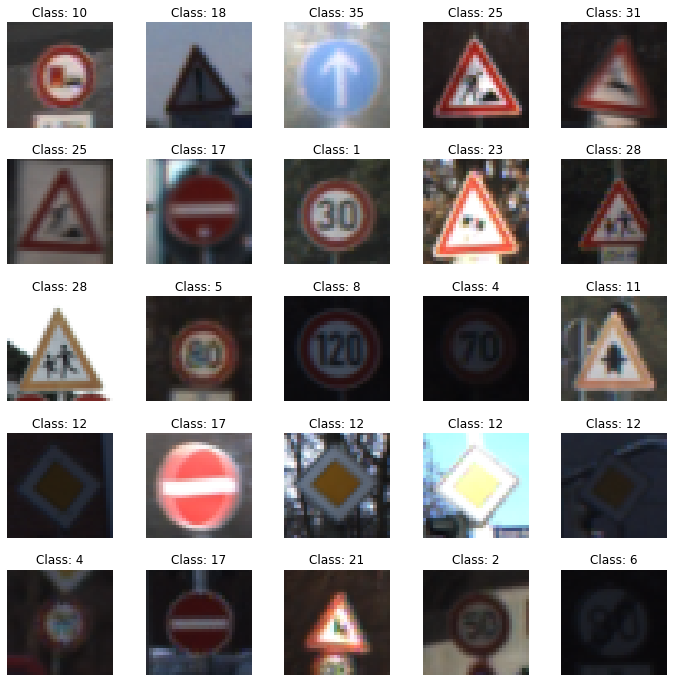

In [17]:
grid_height = 5
grid_width = 5

fig, axes = plt.subplots(nrows=grid_height, ncols=grid_width, figsize=(12, 12))
axes = axes.ravel()
for i in range(grid_height * grid_width):
    # Draft random index to select random training image to plot.
    drafted_index = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[drafted_index])
    axes[i].set_title("Class: " + str(y_train[drafted_index]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)

In [37]:
# Shuffle all sets to remove any bias from the original dataset.
X_train, y_train = shuffle(X_train, y_train)
X_validation, y_validation = shuffle(X_validation, y_validation)
X_test, y_test = shuffle(X_test, y_test)

# Rescale data to [0, 1] range by removing the median value and
# dividing by the possible maximum.
X_train_norm = X_train / 255
X_validation_norm = X_validation / 255
X_test_norm = X_test / 255

print(np.max(X_train_norm))

1.0


In [39]:
autoencoder = keras.models.Sequential()

autoencoder.add(keras.layers.Conv2D(64, (3, 3), padding='same',
                                    input_shape=(32, 32, 3)))
autoencoder.add(keras.layers.BatchNormalization())
autoencoder.add(keras.layers.Activation('relu'))
autoencoder.add(keras.layers.AveragePooling2D((2, 2), padding='same'))

autoencoder.add(keras.layers.Conv2D(32, (3, 3), padding='same'))
autoencoder.add(keras.layers.BatchNormalization())
autoencoder.add(keras.layers.Activation('relu'))
autoencoder.add(keras.layers.AveragePooling2D((2, 2), padding='same'))

autoencoder.add(keras.layers.Conv2D(8, (3, 3), padding='same'))

autoencoder.add(keras.layers.Conv2DTranspose(32, (3, 3), (2, 2), padding='same'))
autoencoder.add(keras.layers.BatchNormalization())
autoencoder.add(keras.layers.Activation('relu'))

autoencoder.add(keras.layers.Conv2DTranspose(64, (3, 3), (2, 2), padding='same'))
autoencoder.add(keras.layers.BatchNormalization())
autoencoder.add(keras.layers.Activation('relu'))

autoencoder.add(keras.layers.Conv2D(3, (3, 3), padding='same',
                                    activation='sigmoid'))

autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 average_pooling2d_10 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 batch_normalization_21 (Bat  (None, 16, 16, 32)      

In [40]:
early_stopping_cb = keras.callbacks.EarlyStopping(min_delta=0.0001,
                                                  patience=10,
                                                  restore_best_weights=True)
lr_reducer_cb = keras.callbacks.ReduceLROnPlateau(patience=5,
                                                  min_lr=0.001)

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                    loss='binary_crossentropy')

# 200 batches with 175 images each.
batch_size = int(X_train_norm.shape[0] / 200)

epochs_info = autoencoder.fit(
    X_train_norm,
    X_train_norm,
    epochs=100,
    callbacks=[early_stopping_cb, lr_reducer_cb],
    validation_data=(X_validation_norm, X_validation_norm)
)

Epoch 1/100
1088/1088 [==============================] - 9s 7ms/step - loss: 0.4756 - val_loss: 0.4602 - lr: 0.0100
Epoch 2/100
1088/1088 [==============================] - 8s 7ms/step - loss: 0.4652 - val_loss: 0.4590 - lr: 0.0100
Epoch 3/100
1088/1088 [==============================] - 8s 7ms/step - loss: 0.4637 - val_loss: 0.4578 - lr: 0.0100
Epoch 4/100
1088/1088 [==============================] - 8s 7ms/step - loss: 0.4630 - val_loss: 0.4566 - lr: 0.0100
Epoch 5/100
1088/1088 [==============================] - 9s 8ms/step - loss: 0.4625 - val_loss: 0.4547 - lr: 0.0100
Epoch 6/100
1088/1088 [==============================] - 8s 7ms/step - loss: 0.4623 - val_loss: 0.4540 - lr: 0.0100
Epoch 7/100
1088/1088 [==============================] - 8s 7ms/step - loss: 0.4620 - val_loss: 0.4570 - lr: 0.0100
Epoch 8/100
1088/1088 [==============================] - 8s 7ms/step - loss: 0.4616 - val_loss: 0.4550 - lr: 0.0100
Epoch 9/100
1088/1088 [==============================] - 8s 7ms/step - l

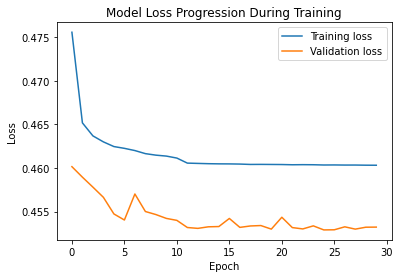

In [41]:
plt.title("Model Loss Progression During Training")
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training loss', 'Validation loss'])
plt.show()

1/1 [==============================] - 0s 17ms/step


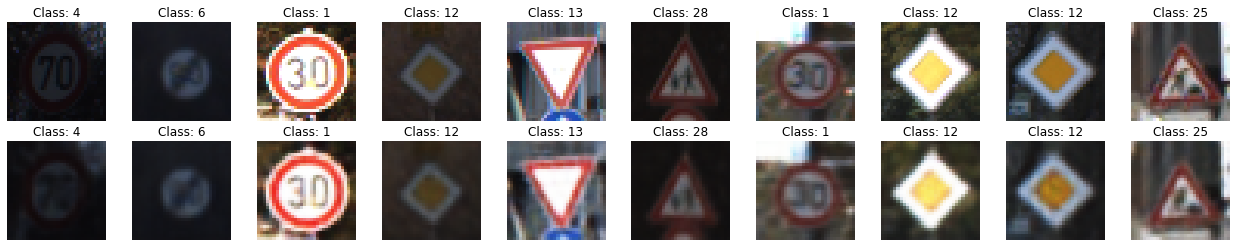

In [43]:
decompressed_images = autoencoder.predict(X_test_norm[:10].reshape(-1, 32, 32, 3))

grid_height = 2
grid_width = 10

fig, axes = plt.subplots(nrows=grid_height, ncols=grid_width, figsize=(22, 4))
axes = axes.ravel()
for i in range(grid_width):
    axes[i].imshow(X_test_norm[i])
    axes[i].set_title("Class: " + str(y_test[i]))
    axes[i].axis('off')
for i in range(grid_width):
    axes[i + 10].imshow(decompressed_images[i])
    axes[i + 10].set_title("Class: " + str(y_test[i]))
    axes[i + 10].axis('off')